## ⬇️ Step 1: Install Dependencies

#### 🧊 pip freeze dependencies

Only run this command when you have installed a new package

In [ ]:
# !pip freeze > requirements.txt

#### 📦 pip install

In [120]:
!pip install -r requirements.txt
!python -m spacy download en_core_web_sm

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


19723.23s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
  Cloning https://github.com/huggingface/accelerate.git (to revision 6719cb6db31f57ea5d2fdb179b0487f51718f353) to /private/var/folders/v9/kls8l3fd0sb1gk104l1y05sh0000gn/T/pip-install-funimhq0/accelerate_10b4bf1299f64b49a6b5d0c2ba2e3da5
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate.git /private/var/folders/v9/kls8l3fd0sb1gk104l1y05sh0000gn/T/pip-install-funimhq0/accelerate_10b4bf1299f64b49a6b5d0c2ba2e3da5
  Running command git rev-parse -q --verify 'sha^6719cb6db31f57ea5d2fdb179b0487f51718f353'
  Running command git fetch -q https://github.com/huggingface/accelerate.git 6719cb6db31f57ea5d2fdb179b0487f51718f353
  Running command git checkout -q 6719cb6db31f57ea5d2fdb179b0487f51718f353
  Resolved https://github.com/huggingface/accelerate.git to commit 6719cb6db31f57ea5d2fdb179b0487f51718f353
  Installing build dependencies ... done
  Getting re

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


19746.10s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.7.1/en_core_web_sm-3.7.1-py3-none-any.whl (12.8 MB)

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# Step 2: Data Preparation

In [3]:
import json
from scripts.prepare_journals_for_training import process_files

# Format each entry in journal_entries as {"date": "2022-05-12", "note": "This is a journal entry."}
journal_entries = process_files('data/raw/journal_entries/')

# Save formatted entries to a JSONL file
with open('data/processed/journal_entries.jsonl', 'w') as outfile:
    for entry in journal_entries:
        json.dump(entry, outfile)
        outfile.write('\n')

All journal entries are in a single `.jsonl` file with the format:
```json
{"date": "2022-05-12", "note": "This is a journal entry."}
{"date": "2022-05-13", "note": "This is a journal entry."}
{"date": "2022-05-14", "note": "This is a journal entry."}
```

## Create DataFrame from Processed Data

In [98]:
import pandas as pd

df = pd.read_json('data/processed/journal_entries.jsonl', lines=True)
print("DF Head\n", df.head(), "\n")

DF Head
         date                                               note
0 2021-12-30  A porn addiction\nPoor performance at work\nNo...
1 2022-03-27  You raped my childhood if any innocence it eve...
2 2022-12-07                                                   
3 2024-01-07  I have to admite something. Although i am sad ...
4 2021-12-20                                                    



## Data Quality Check  

Let's load the journal entries from a JSONL file into a pandas DataFrame and do the following: 

✅ Display the first few rows of the DataFrame for an initial glance at the data.  
✅ Identify and report any missing values in key columns like date and note.  
✅ Ensure all date entries are in the correct Timestamp format.  
✅ Verify that all journal entries are formatted as strings.  

In [96]:
# Check for missing values in both date and note columns
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

# Validate Date Format - if the dates are already in Timestamp format, they are valid
invalid_dates = df[~df['date'].apply(lambda x: isinstance(x, pd.Timestamp))]
print("\nInvalid dates found:\n", invalid_dates)

# Check Journal Entry Format
# Ensure that all journal entries are strings
non_string_entries = df[~df['note'].apply(lambda x: isinstance(x, str))]
print("\nNon-string entries found:\n", non_string_entries)

# Data Consistency and Completeness
# Look for any anomalies in data, such as extremely short or long entries, or entries with unusual characters
print("\nStatistics for 'note' lengths:\n", df['note'].str.len().describe())

Missing values in each column:
 date    0
note    0
dtype: int64

Invalid dates found:
 Empty DataFrame
Columns: [date, note]
Index: []

Non-string entries found:
 Empty DataFrame
Columns: [date, note]
Index: []

Statistics for 'note' lengths:
 count      702.000000
mean      2221.309117
std       3101.092724
min          0.000000
25%        309.500000
50%       1191.500000
75%       3118.500000
max      42126.000000
Name: note, dtype: float64


## 🕵🏽‍♂️ Exploratory Data Analysis (EDA)

We are curious about things like:

1. Number of entries
2. Average length of entries
3. Minimum length of entry
4. Maximum length of entry

In [99]:
num_entries = len(df)
avg_length = df['note'].str.len().mean()
min_length = df['note'].str.len().min()
max_length = df['note'].str.len().max()

print(f"Number of entries: {num_entries}")
print(f"Average length of entries: {avg_length}")
print(f"Minimum length of entry: {min_length}")
print(f"Maximum length of entry: {max_length}")

Number of entries: 702
Average length of entries: 2221.309116809117
Minimum length of entry: 0
Maximum length of entry: 42126


The minimum entry length is 0, which means we have empty journal entries.  

Training the model on blank entries won't do any good, so let's get rid of them.

## 🕳️ Delete empty entries from dataset

In [101]:
# Filter empty entries
empty_entries = df[df['note'].str.len() == 0]

print("Number of empty entries:", len(empty_entries))

df = df[df['note'].str.len() > 0]

empty_entries = df[df['note'].str.len() == 0]

print("Number of empty entries:", len(empty_entries))

Number of empty entries: 0
Number of empty entries: 0


Now what's the minimum entry length?

In [102]:
min_length = df['note'].str.len().min()

print(f"Minimum length of entry: {min_length}")

Minimum length of entry: 1


## 📏 Handle very short entries

All empty entries are removed from dataset but there are still some very short ones. We should handle very short entries too. 

Let's visualize the distribution of entry lengths to get a feel for entry lengths as a whole. 

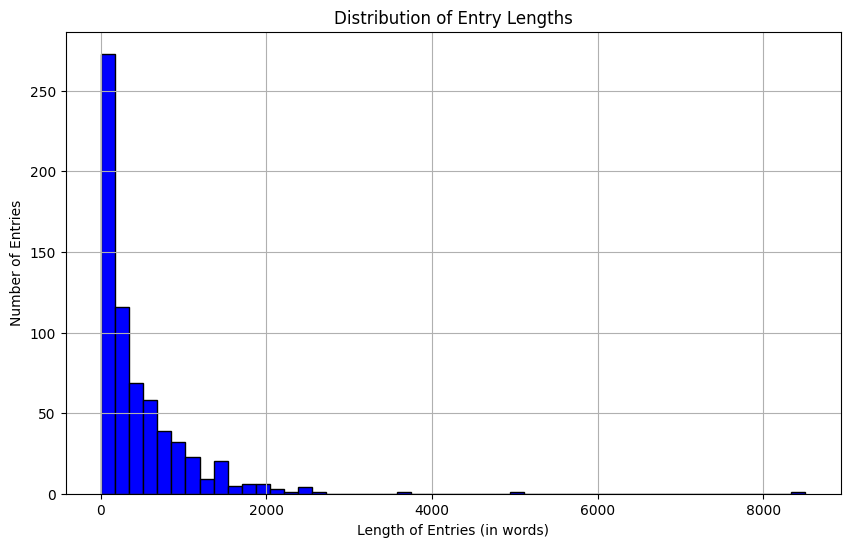

In [103]:
import matplotlib.pyplot as plt

# Calculate the length of each entry (in words)
df['entry_length'] = df['note'].apply(lambda x: len(x.split()))

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(df['entry_length'], bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Entry Lengths')
plt.xlabel('Length of Entries (in words)')
plt.ylabel('Number of Entries')
plt.grid(True)
plt.show()

It is evident that the majority of 702 entries are on the shorter side.

Therefore short is the norm (long live the short king 🤴🏽), but how short is too short? Let's set the threshold to 15 words and see what we get.

In [104]:
word_count_threshold = 15

short_entries = df[df['entry_length'] < word_count_threshold]

print("Number of short entries:", len(short_entries))

Number of short entries: 58


Scan through the entries 10 at a time to see what these very short entries are like.

In [105]:
max_display = 10  # Set the maximum number of entries you want to display
counter = 0

counter, max_display

(0, 10)

In [11]:
while True:
    if counter >= max_display:
        max_display += max_display 
        break
    print(f"Entry {counter}:\n {short_entries.iloc[counter]['note']}\n\n")
    counter += 1

counter, max_display

Entry 0:
 Far from a perfect year 
Left me hungry


Entry 1:
 HMU about 30 mins before hand. 9173927850 -Stefan


Entry 2:
 Damian Killa

Last name: Killa


Entry 3:
 I wasn’t done being bad.


Entry 4:
 I can’t stop being a whore!! I NEED this vaccine!!!


Entry 5:
 Between 3rd and Lexington
Closer to third 
2nd floor

8am


Entry 6:
 * Writing course
* Exercise
* Look at LA apartments


Entry 7:
 You can do better


Entry 8:
 Study for coding interviews
Google UX design course
Pinesbnb


Entry 9:
 This is a message to myself that I am writing openly.




(10, 20)

After scanning them, I see there are some that are meaningless and some I want to keep.  

Since there are only 58 of them, I am going to output them all with `ipywidgets` and choose `Keep` or `Delete` for each one.  

If there were too many short_entries to do this, I could always just delete all short entries entirely.  

However, since our dataset is already small and there are only 58 short entries, I will use this approach. 

In [106]:
entries_ix_to_delete = []
entries_ix_to_delete = [40, 47, 65, 90, 103, 110, 117, 130, 132, 153, 156, 165, 171, 174, 205, 219, 247, 291, 292, 315, 318, 336, 342, 356, 385, 407, 424, 433, 451, 474, 530, 534, 541, 567, 578, 589, 602, 619, 620, 668, 690, 697]

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Display the journal entry for a given index
def show_entry_by_index(dataframe, index):
    if index in dataframe.index:
        entry = dataframe.loc[index]
        print(f"Index: {index}")
        print(f"Date: {entry['date']}")
        print("Note:")
        print(entry['note'])
    else:
        print(f"No entry found at index {index}")

def handle_entry_action(btn, ix, action):
    if action == 'delete':
        entries_ix_to_delete.append(ix)
        btn.description = 'Marked for Deletion'
    else:
        btn.description = 'Kept'
    
    # Disable both buttons to prevent further interaction
    for button in btn.container.children:
        button.disabled = True

for ix in short_entries.index.tolist():
    show_entry_by_index(df, ix)

    # Create a container for buttons
    button_container = widgets.HBox()
    
    # Create a delete button
    delete_btn = widgets.Button(description="Delete")
    delete_btn.container = button_container
    delete_btn.on_click(lambda btn, ix=ix: handle_entry_action(btn, ix, 'delete'))

    # Create a keep button
    keep_btn = widgets.Button(description="Keep")
    keep_btn.container = button_container
    keep_btn.on_click(lambda btn, ix=ix: handle_entry_action(btn, ix, 'keep'))

    # Add buttons to the container
    button_container.children = [delete_btn, keep_btn]
    
    display(button_container)

    # Separate the entries for readability
    print("\n" + "-"*40 + "\n")

In [107]:
print("Num short entries: ", len(short_entries))
print("Num short entries to delete: ", len(entries_ix_to_delete))

Num short entries:  58
Num short entries to delete:  42


Indexes of short entries to delete ends up being: 

`[40, 47, 65, 90, 103, 110, 117, 130, 132, 153, 156, 165, 171, 174, 205, 219, 247, 291, 292, 315, 318, 336, 342, 356, 385, 407, 424, 433, 451, 474, 530, 534, 541, 567, 578, 589, 602, 619, 620, 668, 690, 697]`

Let's delete them 🚮

In [108]:
print("Indexes to delete:", entries_ix_to_delete)
print("Number of entries to delete:", len(entries_ix_to_delete))
print("Number of entries in DataFrame before delete:", len(df))

# Remove the short entries listed in entries_ix_to_delete from the DataFrame
df = df.drop(entries_ix_to_delete)

# Reset the index if you want a continuous index after deletion
df.reset_index(drop=True, inplace=True)
print("Number of entries in DataFrame after delete:", len(df))

# Now df_dropped is your DataFrame with the specified entries removed

Indexes to delete: [40, 47, 65, 90, 103, 110, 117, 130, 132, 153, 156, 165, 171, 174, 205, 219, 247, 291, 292, 315, 318, 336, 342, 356, 385, 407, 424, 433, 451, 474, 530, 534, 541, 567, 578, 589, 602, 619, 620, 668, 690, 697]
Number of entries to delete: 42
Number of entries in DataFrame before delete: 668
Number of entries in DataFrame after delete: 626


In [109]:
# How many short entries remain?
len(df[df['entry_length'] < word_count_threshold])

16

## 🐍 Handle very long entries

The stats of the entry data showed a large distribution in the sizes of the entries.

In [110]:
num_entries = len(df)
avg_length = df['note'].str.len().mean()
min_length = df['note'].str.len().min()
max_length = df['note'].str.len().max()

print(f"Number of entries: {num_entries}")
print(f"Average length of entries: {avg_length}")
print(f"Minimum length of entry: {min_length}")
print(f"Maximum length of entry: {max_length}")

Number of entries: 626
Average length of entries: 2488.011182108626
Minimum length of entry: 13
Maximum length of entry: 42126


**Importance of handling very long entries:**

1. Model Constraints: Models have token limits; long entries might get truncated, losing vital information.
2. Resource Efficiency: Longer entries consume more computational resources, impacting training efficiency.
3. Data Skewness: Extremely long entries can skew the model's understanding, affecting its performance on typical cases.

What we do next will benefit from using a formatted and tokenized dataset, so let's do those two things before proceeding with the rest of handling very long entries. 

# Step 3: Format the Prompts

Format each journal entry with a custom header indicating it's a note by Eevee the Dog.

In [123]:
def formatting_func(row):
    # I'm keeping Eevee the Dog bc it's cute and I couldn't think of anything better
    formatted_text = f"### Date: {row['date']} \n### Note by Eevee the Dog:\n {row['note']}"
    return formatted_text

🤔 Why format training examples this way?

A properly formatted prompt is crucial in effectively training the model and being able to interact with the model in the intended ways.  

Formatting the prompt this way allows us to prompt the fine-tuned model based on the following strategies.

## Prompting Strategies for the Fine-Tuned Model

Our objective is to effectively prompt the fine-tuned model to generate responses based on the trained journal entries.   

### Header Variability  

Employ different versions of the header, keeping the core idea intact. Examples include "Eevee the Dog wrote the following note:" or simply "Note by Eevee the Dog."

### Thematic Prompts  

Utilize themes or contexts from the journal entries to guide the model's responses. For instance, "Reflecting on a day in the park, Eevee the Dog noted:" or "In a mood of contemplation, Eevee the Dog wrote:"

### Questions and Statements  

Directly engage with the content using questions or statements, like "What did Eevee the Dog say about his adventures today?" or "Describe a recent experience of Eevee the Dog."

### Keyword Focus  

Use prevalent keywords or topics from the entries as prompts, such as "Discuss Eevee the Dog's thoughts on happiness," or "Eevee the Dog's perspective on friendship."

### Narrative Starters  

Begin with narrative prompts in line with the journal's style, like "Once upon a time, Eevee the Dog felt..."

## Apply Formatting Function to Dataset

In [19]:
# df['formatted'] = df.apply(formatting_func, axis=1)
# df['formatted']

0      ### Date: 2021-12-30 00:00:00 \n### Note by Ee...
1      ### Date: 2022-03-27 00:00:00 \n### Note by Ee...
2      ### Date: 2024-01-07 00:00:00 \n### Note by Ee...
3      ### Date: 2023-03-02 00:00:00 \n### Note by Ee...
4      ### Date: 2023-04-10 00:00:00 \n### Note by Ee...
                             ...                        
621    ### Date: 2021-09-03 00:00:00 \n### Note by Ee...
622    ### Date: 2021-08-21 00:00:00 \n### Note by Ee...
623    ### Date: 2023-02-27 00:00:00 \n### Note by Ee...
624    ### Date: 2022-05-23 00:00:00 \n### Note by Ee...
625    ### Date: 2021-08-10 00:00:00 \n### Note by Ee...
Name: formatted, Length: 626, dtype: object

# Step: 🤖 Load the Base Model

In [20]:
import torch
from transformers import AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "TheBloke/dolphin-2.5-mixtral-8x7b-GGUF"

# UNCOMMENT BELOW TO LOAD MODEL
# -----------------------------
# nf4_config = BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_use_double_quant=True,
#     bnb_4bit_quant_type="nf4",
#     bnb_4bit_compute_dtype=torch.bfloat16
# )

model = AutoModelForCausalLM.from_pretrained(
    base_model_id, 
    quantization_config=nf4_config, 
    device_map="auto",
    use_cache=False,
    attention_implementation="flash_attention_2"
)

# Set the device to GPU (if available)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

NameError: name 'nf4_config' is not defined

# Step: 🪙 Load Tokenizer

In [112]:
from transformers import AutoTokenizer

tokenizer_model_id = "mistralai/Mixtral-8x7B-v0.1"

tokenizer = AutoTokenizer.from_pretrained(tokenizer_model_id)

tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"
tokenizer.add_eos_token = True
tokenizer.add_bos_token = True

## Tokenize Formatted Dataset

In [97]:
def generate_and_tokenize_row(row):
    result = tokenizer(
        formatting_func(row),
        # truncation=True,
        # max_length=max_length,
        # padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [113]:
def count_tokens(row):
    # Tokenize the entry and return the count of tokens
    tokenized = tokenizer(formatting_func(row))
    return len(tokenized['input_ids'])

df['token_count'] = df.apply(count_tokens, axis=1)

# Step: Determine Max Sequence Length

count      626.000000
mean       655.108626
std        785.571473
min         40.000000
25%        166.750000
50%        401.000000
75%        878.000000
max      10621.000000
Name: token_count, dtype: float64
Proposed threshold for very long entries: 1976.25 tokens


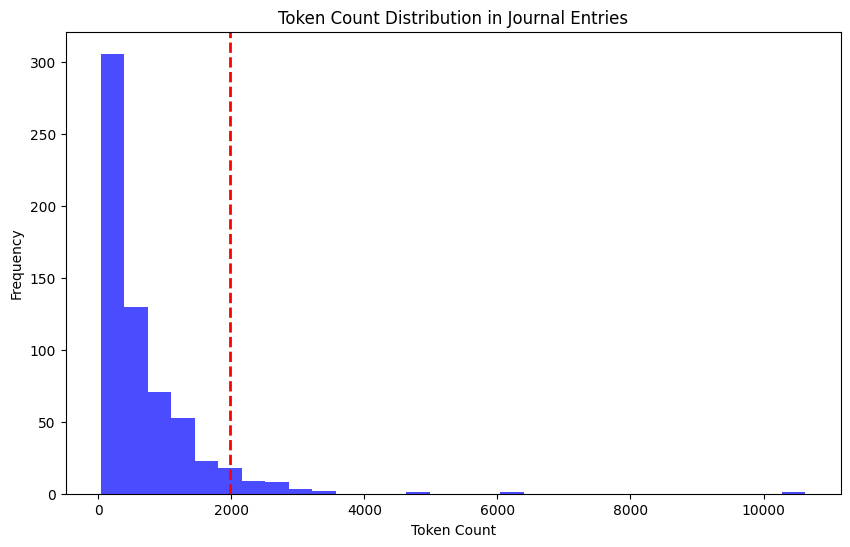

Number of very long entries: 32


In [116]:
import matplotlib.pyplot as plt
import numpy as np

# Descriptive statistics to understand the distribution
print(df['token_count'].describe())

# Identify a potential threshold for long entries, e.g., using the 95th percentile
token_threshold = df['token_count'].quantile(0.95)
print(f"Proposed threshold for very long entries: {token_threshold} tokens")

# Dynamic binning for histogram based on token data range
bin_width = int(np.ceil((df['token_count'].max() - df['token_count'].min()) / 30))
bins = range(int(df['token_count'].min()), int(df['token_count'].max()) + bin_width, bin_width)

# Plotting a histogram for visual analysis
plt.figure(figsize=(10, 6))
plt.hist(df['token_count'], bins=bins, color='blue', alpha=0.7)
plt.axvline(token_threshold, color='red', linestyle='dashed', linewidth=2)
plt.title('Token Count Distribution in Journal Entries')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.show()

# Filtering the DataFrame for very long entries based on token count
long_entries_df = df[df['token_count'] > token_threshold]
print(f"Number of very long entries: {len(long_entries_df)}")


Propsed threshold is ~1900 tokens however this seems a bit long as the standard for many modes is only 512 tokens.

Let's stay in the range of 1900 but decrease to 1500. 

### Set Max Sequence Length

`max_sequence_length` should cover most of the training examples but should also not be too big. The bigger `max_sequence_length`, the more compute resources and time required to train the model.

The goal is to choose the smallest possible `max_sequence_length` the covers the majority of the dataset.

In [122]:
# max_sequence_length = 1900 # tokens
max_sequence_length = 1500 # tokens

# prompt_token_count = tokenizer(formatting_func(""))

print(formatting_func(""))

TypeError: string indices must be integers, not 'str'

In [141]:
long_entries_df = df[df['token_count'] > max_sequence_length]
print(f"Number of very long entries: {len(long_entries_df)}")

Number of very long entries: 62


### ✂️ Split longer entries into smaller subsets

Include a small overlap (e.g., part of the last sentence from the previous segment) in each new segment.  

This overlap can help maintain context continuity across segments, especially if the segmentation cuts through important narrative or thematic elements.

In [136]:
import spacy
nlp = spacy.load("en_core_web_sm")

def segment_entry(row, max_token_length=max_sequence_length):
    """
    Segments a long journal entry into smaller parts based on token count and natural sentence boundaries.

    Args:
    entry (str): The journal entry to be segmented.
    max_token_length (int): The maximum token length for each segment.

    Returns:
    List[str]: A list of segmented journal entries.
    """
    prompt_template = f"### Date: {row['date']} \n### Note by Eevee the Dog:\n"
    prompt_tokens = tokenizer.tokenize(prompt_template)

    doc = nlp(row["note"])
    segments = []
    current_tokens = []

    for sent in doc.sents:
        # Tokenize the sentence
        sentence_tokens = tokenizer.tokenize(sent.text)

        if len(prompt_tokens) + len(current_tokens) + len(sentence_tokens) > max_token_length:
            # Convert current segment to text and store it
            segment_text = tokenizer.convert_tokens_to_string(current_tokens)
            segments.append(segment_text.strip())
            
            # Start new segment with prompt tokens and current sentence
            # current_tokens = prompt_tokens.copy() + sentence_tokens
            current_tokens = sentence_tokens
        else:
            current_tokens.extend(sentence_tokens)

    # Add the last segment if not empty
    if current_tokens:
        segment_text = tokenizer.convert_tokens_to_string(current_tokens).strip()
        segments.append(segment_text)

    return segments


In [137]:
# Selecting the first long entry for demonstration
long_entry = long_entries_df.iloc[0]

segments = segment_entry(long_entry)

# Print the segmented entries
for i, segment in enumerate(segments, 1):
    print(f"🍊 Segment {i}:\n{segment}\n\n")


🍊 Segment 1:
I did not wake up at 6:30 as my alarm clock intended however I was lights out and in bed at 10:30. Unfortunately I was arguing with Josh in my head until midnight. I ended up having an incredible day. I woke up rested, I wrote a shit ton, went on a thirty minute walk and thought good thoughts. 

 Worked on my second brain. 
 Came to some good conclusions. 
 One of which I started writing about yesterday. 
 Stop giving so many fucks! 
 My whole world was Jason and Josh and it consumed me. 
 Going to George’s pool party reminded me of all the connections there are to be made out there. 
 All the wonderful people. 
 There is a whole world out there fay beyond our little exclusive friend group. 
 Far beyond LA. 
 A whole great, big world with all kinds of adventures and explorations. 

 I was sitting in the backyard yesterday when josh and Jason came home. 
 Josh came to the back door and we had a little exchange. 
 I complimented his shorts. He told me where he got them. 
 “C

## Apply segmentation to entire DF

In [144]:
# Apply segmentation to each row in long_entries_df
segmented_series = long_entries_df.apply(segment_entry, axis=1)
long_entries_df = long_entries_df.assign(segments=segmented_series)

# Now, long_entries_df has a new column 'segments' containing the segmented entries
long_entries_df.head()


,date,note,entry_length,token_count,segments
4,2023-04-10,I did not wake up at 6:30 as my alarm clock in...,1687,2397,[I did not wake up at 6:30 as my alarm clock i...
9,2023-04-07,"It’s been a tough couple weeks. \nYesterday, t...",1356,1785,"[It’s been a tough couple weeks. \n Yesterday,..."
14,2021-09-27,Letting myself be happy\nWas key\nTo invite in...,1794,2790,[Letting myself be happy\nWas key\nTo invite i...
23,2021-05-18,And I know that it will get what it want if it...,2169,2715,[And I know that it will get what it want if i...
39,2023-03-01,I’m doing my best. And my best begins with bei...,1728,2138,[I’m doing my best. And my best begins with be...


### 🖇️ Integrate Segments Into Training Data

🥞 **Flatten the Segmented Data**  
  
Since `long_entries_df['segments']` now contains lists of segments, flatten these lists so that each segment becomes a separate row in a new DataFrame.  

In [145]:
# Flatten the DataFrame
flattened_df = pd.DataFrame([(date, segment) 
                             for date, segments in zip(long_entries_df['date'], long_entries_df['segments'])
                             for segment in segments], 
                            columns=['date', 'note'])

# Display the new DataFrame structure
print(flattened_df.head())

        date                                               note
0 2023-04-10  I did not wake up at 6:30 as my alarm clock in...
1 2023-04-10  The disappearance of Adriano as a friend from ...
2 2023-04-07  It’s been a tough couple weeks. \n Yesterday, ...
3 2023-04-07  My hunger filled my body like the steam of a s...
4 2021-09-27  Letting myself be happy\nWas key\nTo invite in...


Drop the long entries from the original DataFrame.  

Before concatenating, make sure the columns in flattened_df and df_shortened align.

In [146]:
# Drop the original long entries from the original DataFrame
df_shortened = df.drop(long_entries_df.index)

# Before concatenating, make sure the columns in flattened_df and df_shortened align
# They should both have the same columns, e.g., 'date' and 'note'
print("Columns in df_shortened:", df_shortened.columns)
print("Columns in flattened_df:", flattened_df.columns)

Columns in df_shortened: Index(['date', 'note', 'entry_length', 'token_count'], dtype='object')
Columns in flattened_df: Index(['date', 'note'], dtype='object')


In [147]:
# Select relevant columns from df_shortened to match flattened_df
df_shortened = df_shortened[['date', 'note']]

print("Columns in df_shortened:", df_shortened.columns)
print("Columns in flattened_df:", flattened_df.columns)


Columns in df_shortened: Index(['date', 'note'], dtype='object')
Columns in flattened_df: Index(['date', 'note'], dtype='object')


In [ ]:
# Concatenate df_shortened_aligned and flattened_df
combined_df = pd.concat([df_shortened, flattened_df], ignore_index=True)

# Display the combined DataFrame structure
print(combined_df.head())

In [ ]:
# Check for duplicates based on the 'note' column
duplicates = combined_df[combined_df.duplicated(subset=['note'], keep=False)]
print(duplicates)

# Drop duplicates based on the 'note' column
unique_df = combined_df.drop_duplicates(subset=['note'])

# Display the structure of the unique DataFrame
print(unique_df.head())


Verify no more duplicates

In [150]:
duplicates = unique_df[unique_df.duplicated(subset=['note'], keep=False)]
print(duplicates)

Empty DataFrame
Columns: [date, note]
Index: []


# Step: Prepare Data for Training
Convert the final DataFrame into a Hugging Face Dataset

In [152]:
final_df = combined_df[['date', 'note']]

In [154]:
from datasets import Dataset

# Convert the DataFrame into a Hugging Face Dataset
dataset = Dataset.from_pandas(final_df)


Dataset({
    features: ['date', 'note'],
    num_rows: 704
})

###  Split Data into Train and Validation Sets

In [158]:
# Split the dataset into training and validation sets
train_test_split_ratio = 0.9  # 90% for training, 10% for validation
split_datasets = dataset.train_test_split(test_size=(1 - train_test_split_ratio))

train_dataset = split_datasets['train']
eval_dataset = split_datasets['test']

# Checking the first few examples of the training and validation sets
print("Training Set:")
print(train_dataset)
print("Validation Set:")
print(eval_dataset)

Training Set:
Dataset({
    features: ['date', 'note'],
    num_rows: 633
})
Validation Set:
Dataset({
    features: ['date', 'note'],
    num_rows: 71
})


In [163]:
row = train_dataset[0]
# print(formatting_func(row))
x = tokenizer(
        formatting_func(row),
        truncation=True,
        max_length=max_sequence_length,
        padding="max_length",
    )
x

{'input_ids': [1, 774, 5491, 28747, 28705, 28750, 28734, 28750, 28740, 28733, 28734, 28783, 28733, 28740, 28783, 28705, 28734, 28734, 28747, 28734, 28734, 28747, 28734, 28734, 28705, 13, 27332, 6096, 486, 413, 21111, 28706, 272, 13311, 28747, 13, 28705, 28740, 28723, 9900, 477, 17396, 28709, 13, 28750, 28723, 4121, 26469, 266, 28705, 13, 28770, 28723, 1725, 4649, 315, 5591, 778, 3536, 302, 19587, 20637, 13, 28781, 28723, 11482, 276, 325, 7781, 262, 1772, 28731, 13, 28782, 28723, 23330, 385, 24743, 13, 28784, 28723, 315, 28877, 10270, 13, 28787, 28723, 25363, 1337, 2450, 13, 28783, 28723, 4157, 420, 595, 13, 28774, 28723, 330, 487, 28715, 1780, 28717, 13, 28740, 28734, 28723, 5702, 424, 28709, 16073, 603, 28709, 28705, 13, 28740, 28740, 28723, 5376, 691, 367, 20368, 12216, 28764, 13, 28740, 28750, 28723, 5013, 1437, 14812, 463, 7645, 262, 13, 28740, 28770, 28723, 9764, 380, 367, 326, 1495, 13, 13, 28740, 28723, 11482, 276, 325, 362, 3689, 473, 28731, 13, 28750, 28723, 11641, 16159, 1812

### Tokenize the Data Sets

In [157]:
def generate_and_tokenize_prompt(row):
    result = tokenizer(
        formatting_func(row),
        truncation=True,
        max_length=max_sequence_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [159]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Map:   0%|          | 0/633 [00:00<?, ? examples/s]

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Map:   0%|          | 0/71 [00:00<?, ? examples/s]

In [164]:
tokenized_train_dataset

Dataset({
    features: ['date', 'note', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 633
})

In [172]:
# Inspect first few examples of the tokenized training dataset
print("Training Dataset Examples:")
for i in range(5):
    example = tokenized_train_dataset[i]
    print(f"Example {i+1} - Date: {example['date']}")
    print(f"Input IDs: {example['input_ids'][:10]}... [Total: {len(example['input_ids'])}]")
    print(f"Attention Mask: {example['attention_mask'][:10]}...")
    print(f"Labels: {example['labels'][:10]}...\n")


Training Dataset Examples:
Example 1 - Date: 2021-08-18 00:00:00
Input IDs: [1, 774, 5491, 28747, 28705, 28750, 28734, 28750, 28740, 28733]... [Total: 1500]
Attention Mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]...
Labels: [1, 774, 5491, 28747, 28705, 28750, 28734, 28750, 28740, 28733]...

Example 2 - Date: 2021-08-08 00:00:00
Input IDs: [1, 774, 5491, 28747, 28705, 28750, 28734, 28750, 28740, 28733]... [Total: 1500]
Attention Mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]...
Labels: [1, 774, 5491, 28747, 28705, 28750, 28734, 28750, 28740, 28733]...

Example 3 - Date: 2022-04-03 00:00:00
Input IDs: [1, 774, 5491, 28747, 28705, 28750, 28734, 28750, 28750, 28733]... [Total: 1500]
Attention Mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]...
Labels: [1, 774, 5491, 28747, 28705, 28750, 28734, 28750, 28750, 28733]...

Example 4 - Date: 2023-08-21 00:00:00
Input IDs: [1, 774, 5491, 28747, 28705, 28750, 28734, 28750, 28770, 28733]... [Total: 1500]
Attention Mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]...
Labels: [1, 774, 5491, 28

In [169]:
# Inspect first few examples of the tokenized training dataset
print("Training Dataset Examples:")
for i in range(5):
    print(f"Example {i+1}: {tokenized_train_dataset[i]['input_ids']}")

# Inspect first few examples of the tokenized validation dataset
print("\nValidation Dataset Examples:")
for i in range(5):
    print(f"Example {i+1}: {tokenized_val_dataset[i]['input_ids']}")


Training Dataset Examples:
Example 1: [1, 774, 5491, 28747, 28705, 28750, 28734, 28750, 28740, 28733, 28734, 28783, 28733, 28740, 28783, 28705, 28734, 28734, 28747, 28734, 28734, 28747, 28734, 28734, 28705, 13, 27332, 6096, 486, 413, 21111, 28706, 272, 13311, 28747, 13, 28705, 28740, 28723, 9900, 477, 17396, 28709, 13, 28750, 28723, 4121, 26469, 266, 28705, 13, 28770, 28723, 1725, 4649, 315, 5591, 778, 3536, 302, 19587, 20637, 13, 28781, 28723, 11482, 276, 325, 7781, 262, 1772, 28731, 13, 28782, 28723, 23330, 385, 24743, 13, 28784, 28723, 315, 28877, 10270, 13, 28787, 28723, 25363, 1337, 2450, 13, 28783, 28723, 4157, 420, 595, 13, 28774, 28723, 330, 487, 28715, 1780, 28717, 13, 28740, 28734, 28723, 5702, 424, 28709, 16073, 603, 28709, 28705, 13, 28740, 28740, 28723, 5376, 691, 367, 20368, 12216, 28764, 13, 28740, 28750, 28723, 5013, 1437, 14812, 463, 7645, 262, 13, 28740, 28770, 28723, 9764, 380, 367, 326, 1495, 13, 13, 28740, 28723, 11482, 276, 325, 362, 3689, 473, 28731, 13, 28750, 2